# Clustering Without Volvanic Activities

In [1]:
%load_ext autoreload
%autoreload 2

from netCDF4 import Dataset
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage import gaussian_filter1d
from scipy import signal
import cartopy.crs as ccrs
import cartopy
import ipywidgets as widgets
from ipywidgets import interact
from sklearn.cluster import KMeans
from itertools import groupby
from sklearn.cluster import KMeans
from settings import path_data
from plot_map import plot_map

In [2]:
ds_solar = xr.open_dataset(path_data / 'Solar_forcing_1st_mill.nc')
ds_volc = xr.open_dataset(path_data / 'Volc_Forc_AOD_1st_mill.nc')
ds_temp_r1 = xr.open_dataset(path_data / 'T2m_R1_ym_1stMill.nc')

In [3]:
# remove the volcanic eruption data + 5 year post volcanic time window -> remove 243 years
eruption_years = np.nonzero(ds_volc.AOD.values.flatten())[0]
years_to_be_removed = []
for yr in eruption_years:
    years_to_be_removed.append(np.arange(yr, yr+6, 1))
years_to_be_removed = np.asarray(years_to_be_removed)
years_to_be_removed = years_to_be_removed.reshape((np.shape(years_to_be_removed)[0]*np.shape(years_to_be_removed)[1]))
years_to_be_removed.sort()
years_to_be_removed = [x[0] for x in groupby(years_to_be_removed)]
years_to_be_removed = np.asarray(years_to_be_removed)
years_to_be_removed = years_to_be_removed[years_to_be_removed < 999]

volcanic_boolean_array = np.ones(np.shape(ds_volc.AOD.values.flatten()), dtype=bool)
volcanic_boolean_array[years_to_be_removed] = 0

kept_years = np.arange(1, 1000, 1)
kept_years = kept_years[volcanic_boolean_array]

temp = ds_temp_r1['T2m'].values
temp = temp[volcanic_boolean_array, :, :]

In [4]:
# compare wih clustering on relative changes of temperature (difference to temperature of previous year)

X_rel = temp.copy()
print(np.shape(X_rel))
X_rel = X_rel.reshape(756, -1).transpose()
for i in np.arange(1, 756):
    X_rel[:, i] = X_rel[:, i] - X_rel[:, i-1]
X_rel = X_rel[:, 1:]
kmeans_rel = KMeans(n_clusters=10, random_state=0).fit(X_rel)

(756, 96, 192)


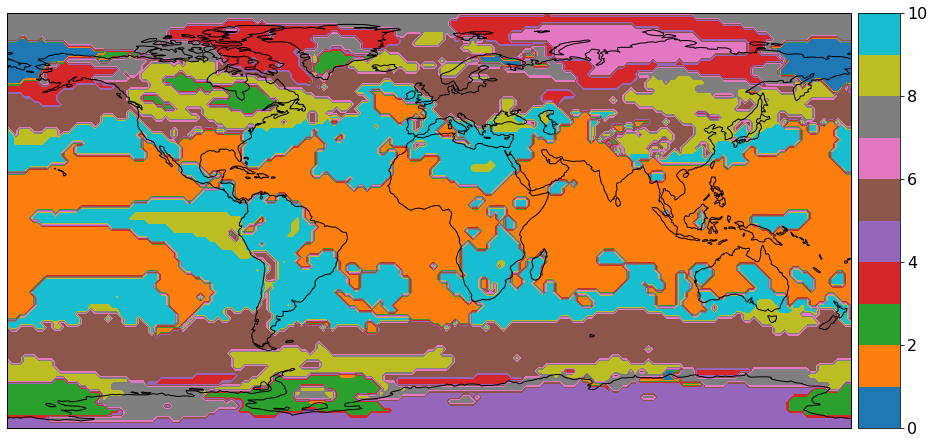

In [5]:
clusters_rel = kmeans_rel.labels_.reshape(96, 192)
plot_map(clusters_rel+0.5)

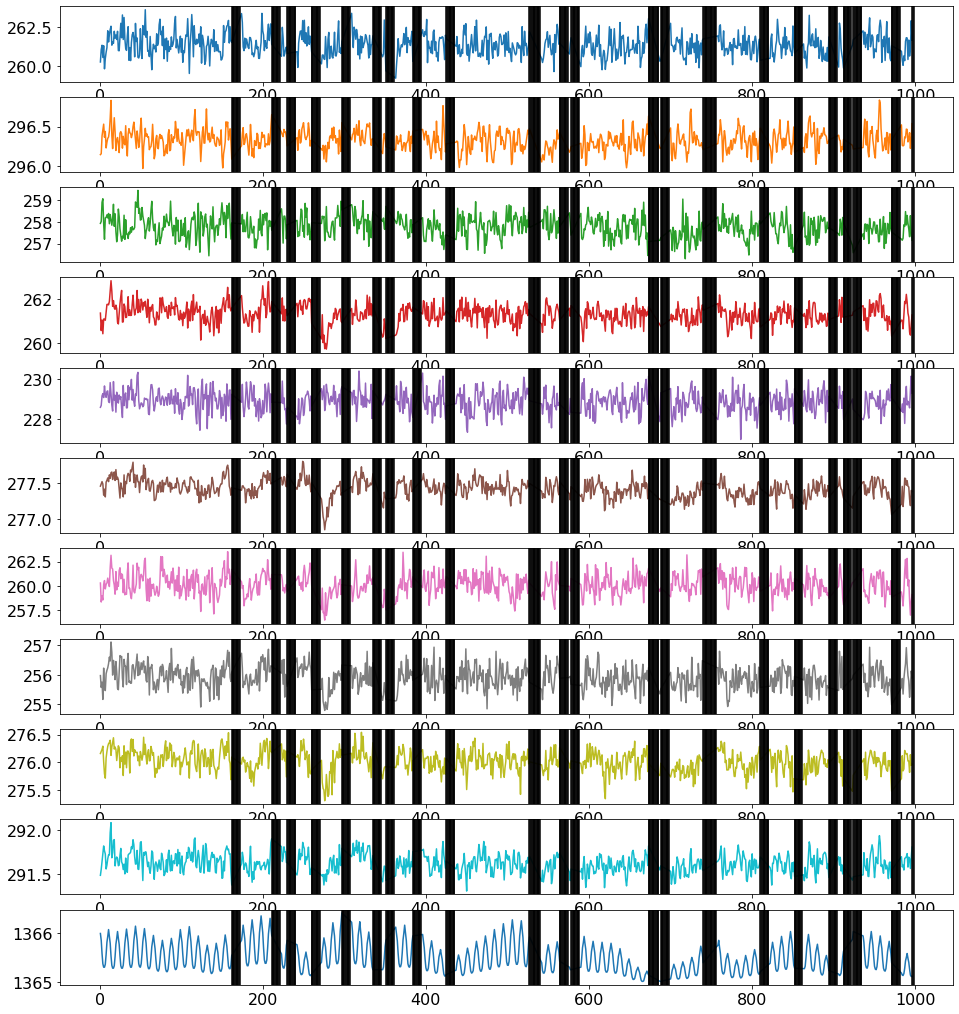

In [6]:
mean_temp_clusters = []
for c in np.unique(clusters_rel):
    temps_cluster = temp[:, clusters_rel == c]
    temps_cluster = np.mean(temps_cluster, axis=1)
    mean_temp_clusters.append(temps_cluster)
    
# solar irradiance for kept years
kept_sol = ds_solar.TSI.values.flatten()[volcanic_boolean_array]

fig, axes = plt.subplots(11, 1, figsize=(16, 18))
for i, ax in enumerate(axes.flatten()):
    if i<10:
        ax.plot(kept_years, mean_temp_clusters[i], color=cm.tab10((i+0.5)/10))
        for y in years_to_be_removed:
            ax.axvline(x=y, ymin=0, ymax=1, c='k')
    else:
        ax.plot(kept_years, kept_sol)
        for y in years_to_be_removed:
            ax.axvline(x=y, ymin=0, ymax=1, c='k')